In [4]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose



# Time Series Missing Data Imputation

## Generate data

,sales,ad_spent
date,,
2022-01-01,NaN,6.593897
2022-01-02,41.116283,2.503652
2022-01-03,53.683909,0.000000
2022-01-04,32.968355,0.000000
2022-01-05,-12.254839,0.000000


% missing data in sales:  24.10958904109589


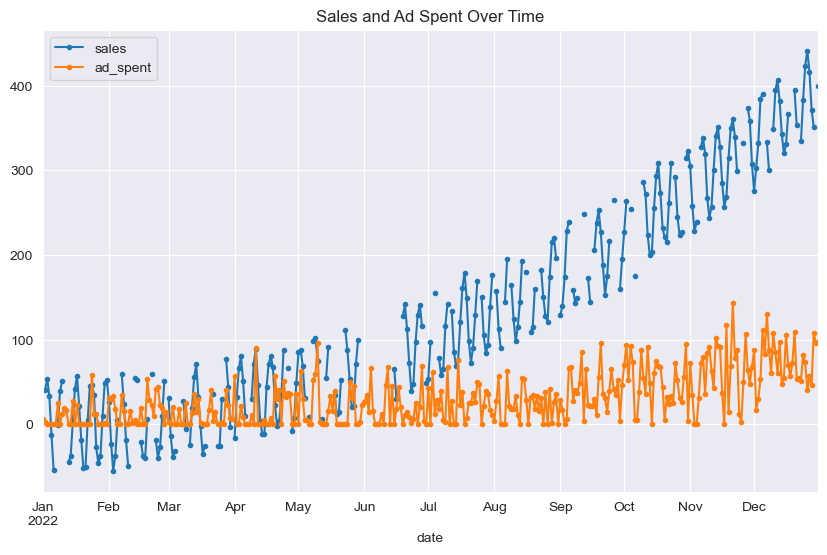

Correlation between sales and ad_spent:  0.6572306797100969


In [13]:
sns.set_style("darkgrid")

np.random.seed(0)

# Define the start date
start_date = datetime(2022, 1, 1)

# Generate dates for 365 days
dates = [start_date + timedelta(days=i) for i in range(365)]

# Generate more pronounced trend component (increasing linearly)
trend = np.power(np.linspace(0.1, 20, 365), 2)

# Generate more pronounced seasonal component (sinusoidal pattern) with weekly period
seasonal = 50 * np.sin(np.linspace(0, 2 * np.pi * 52, 365)) # 52 weeks in a year

# Generate random noise
noise = np.random.normal(0, 5, 365)

# Combine components to generate sales data
sales = trend + seasonal + noise

# Create ad_spent feature
# Using a scaled version of sales and adding more noise
ad_spent = 0.2 * sales + np.random.normal(0, 30, 365)  # Increased the noise and decreased the scale factor
ad_spent = np.maximum(ad_spent, 0)  # Making sure all ad_spent values are non-negative

# Create a dataframe
df = pd.DataFrame(
    {
        'date': dates,
        'sales': sales,
        'ad_spent': ad_spent
    }
)

# Set the date as the index
df.set_index('date', inplace=True)

# Generate missing values for a larger gap
for i in range(150, 165):  # A 15-day gap
    df.iloc[i, df.columns.get_loc('sales')] = np.nan

# Randomly choose indices for missing values (not including the already missing gap)
random_indices = random.sample(list(set(range(365)) - set(range(150,165))), int(0.20 * 365))

# Add random missing values
for i in random_indices:
    df.iloc[i, df.columns.get_loc('sales')] = np.nan

# Display the dataframe
display(df.head())

# Print the percentage of missing values 
print('% missing data in sales: ', 100*df['sales'].isnull().sum()/len(df))

# Plot the data
df[['sales', 'ad_spent']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')
plt.show()

# Print correlation between sales and ad_spent
print("Correlation between sales and ad_spent: ", df['sales'].corr(df['ad_spent']))







## Delete

,sales,ad_spent
date,,
2022-01-02,41.116283,2.503652
2022-01-03,53.683909,0.000000
2022-01-04,32.968355,0.000000
2022-01-05,-12.254839,0.000000
2022-01-06,-53.493394,0.000000


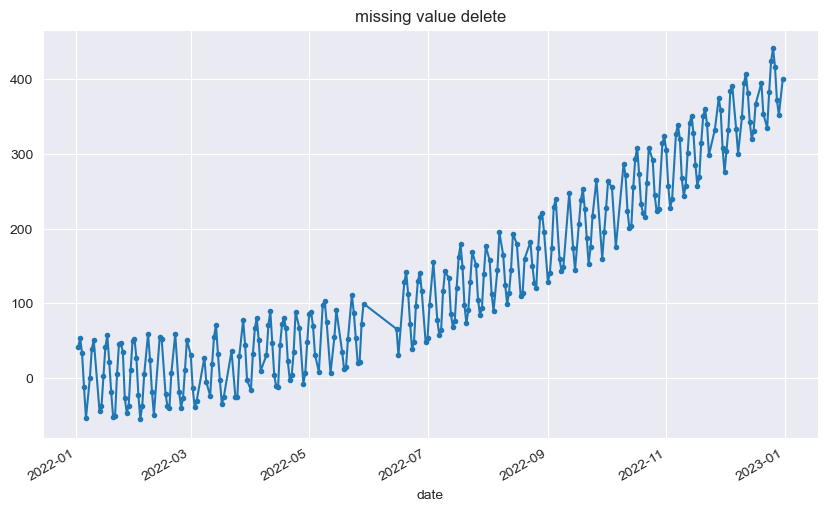

In [14]:
df_delete = df.copy()

df_delete.dropna(inplace=True)

#display the dateframe
display(df_delete.head())

df_delete['sales'].plot(style='.-', figsize=(10, 6), title='missing value delete')

plt.show()

## constant imputation

Text(0, 0.5, 'Sales')

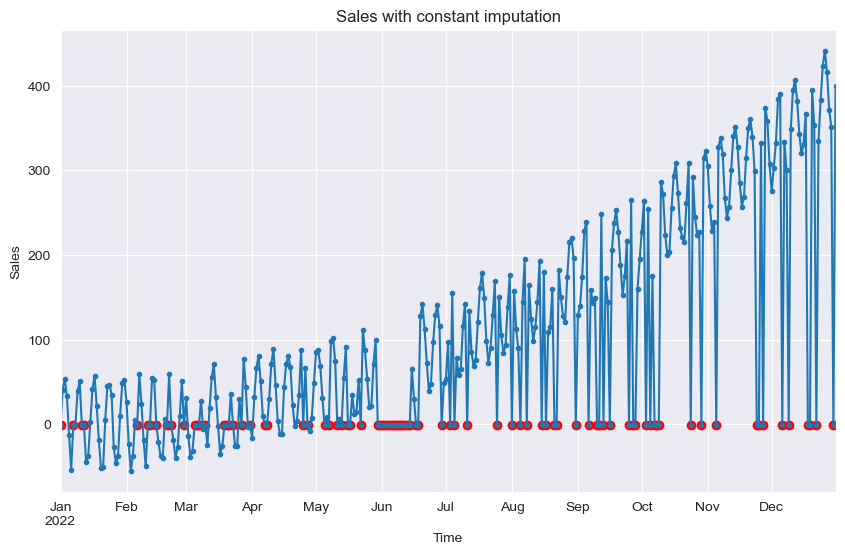

In [16]:
df_imputed = df.fillna(-1)

df_imputed['sales'].plot(style='.-', figsize=(10, 6), title='Sales with constant imputation')

# add points where data was impute the with red color
plt.scatter(df_imputed[df['sales'].isnull()].index, df_imputed[df['sales'].isnull()]['sales'], color='red')

plt.xlabel('Time')
plt.ylabel('Sales')


## Last Observation cover forward


C:\Users\yacht\AppData\Local\Temp\ipykernel_26832\1568199281.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputed = df.fillna(method='ffill')


Text(0, 0.5, 'Sale')

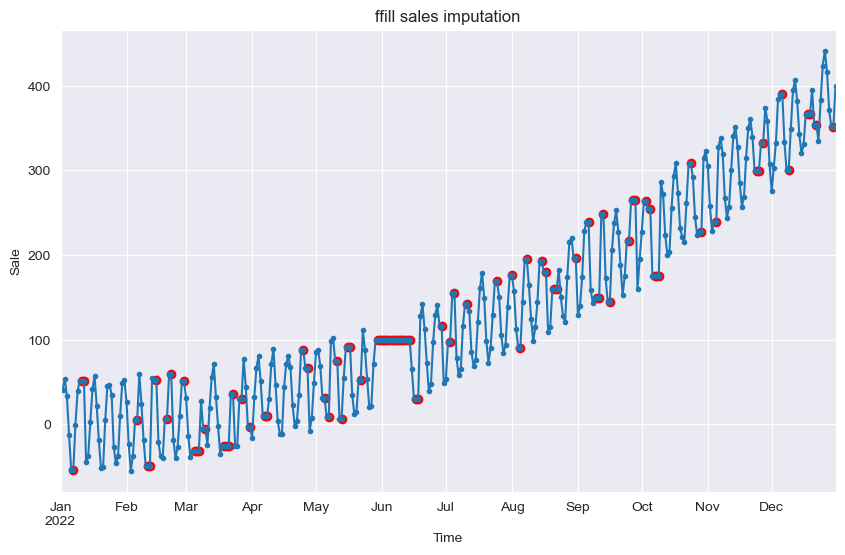

In [18]:
df_imputed = df.fillna(method='ffill')

# plot the main line with markers
df_imputed['sales'].plot(style='.-', figsize=(10, 6), title='ffill sales imputation')

# add points where data has imputed with red color

plt.scatter(df_imputed[df['sales'].isnull()].index, df_imputed[df['sales'].isnull()]['sales'], color='red')

plt.xlabel('Time')
plt.ylabel('Sale')

# Next observation carred backward

C:\Users\yacht\AppData\Local\Temp\ipykernel_26832\3361957415.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputed = df.fillna(method='bfill')


Text(0, 0.5, 'Sales')

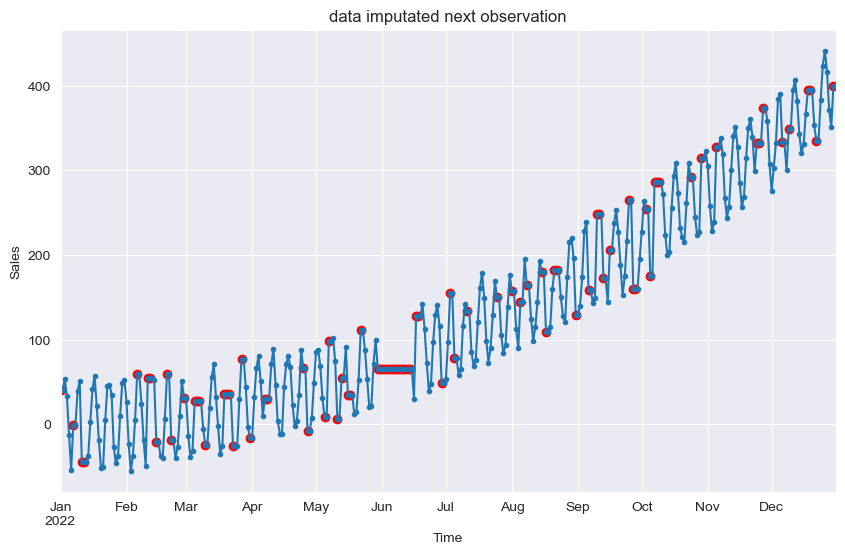

In [21]:
df_imputed = df.fillna(method='bfill')

df_imputed['sales'].plot(style='.-', figsize=(10, 6), title='data imputated next observation')

plt.scatter(df_imputed[df['sales'].isnull()].index, df_imputed[df['sales'].isnull()]['sales'], color='red')

plt.xlabel('Time')
plt.ylabel('Sales')





# Mean/Median/mode Imputation

Text(0, 0.5, 'Sales')

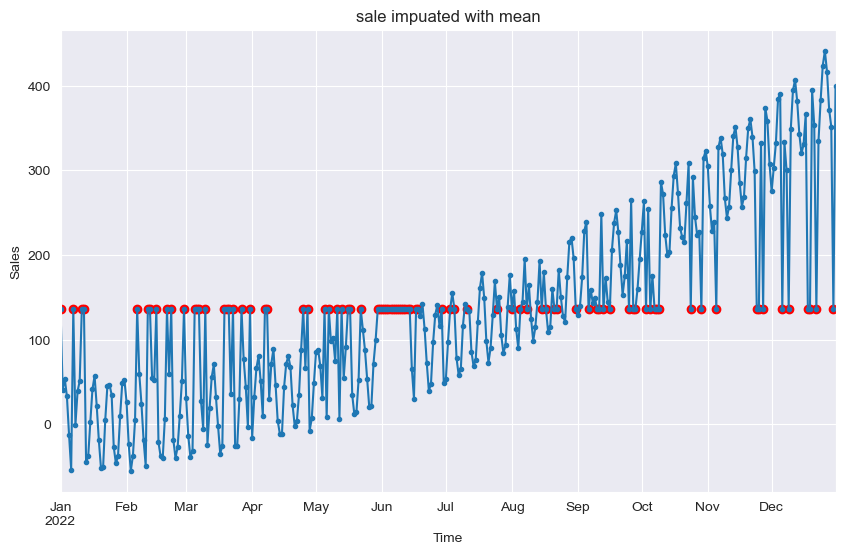

In [23]:
df_imputed = df.fillna(df['sales'].mean())

df_imputed['sales'].plot(style='.-', figsize=(10, 6), title='sale impuated with mean')

plt.scatter(df_imputed[df['sales'].isnull()].index, df_imputed[df['sales'].isnull()]['sales'], color='red')

plt.xlabel('Time')
plt.ylabel('Sales')



## Rolling statistics imputation

Text(0, 0.5, 'Sales')

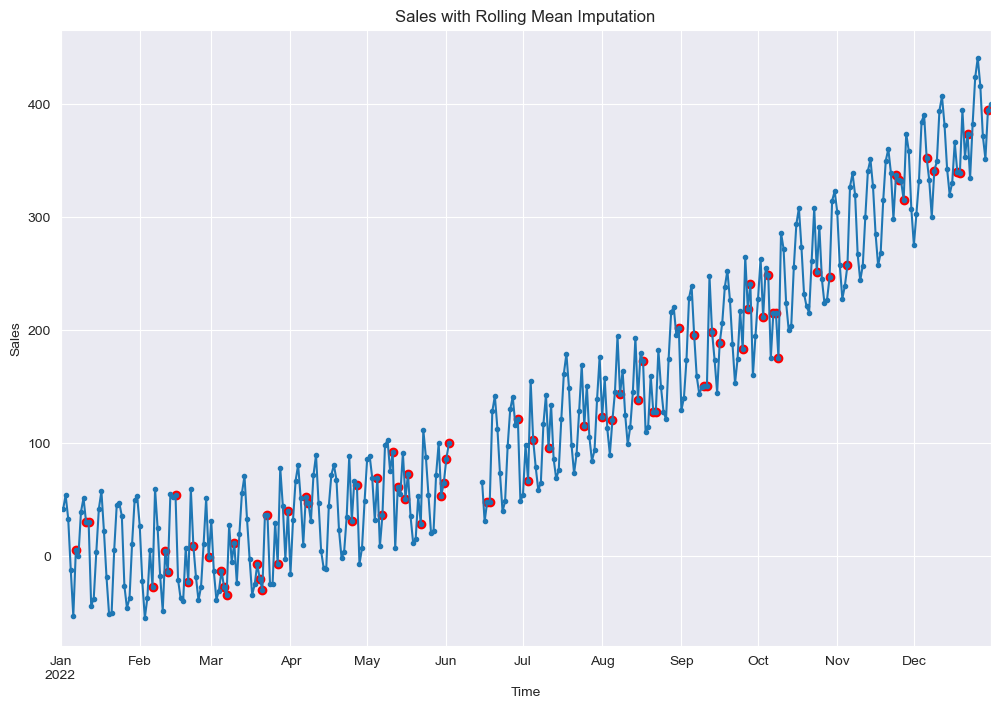

In [27]:
# Make a copy of the original DataFrame
df_copy = df.copy()

# Mark the missing values before imputation
imputed_indices = df_copy[df_copy['sales'].isnull()].index


# Apply the rolling mean imputation method
df_copy['sales'] = df_copy['sales'].fillna(df_copy['sales'].rolling(window=4, min_periods=1).mean().shift(1))

# Plot the main line with markers
df_copy['sales'].plot(style='.-', figsize=(12,8), title='Sales with Rolling Mean Imputation')

# Add points where data was imputed with red color
plt.scatter(imputed_indices, df_copy.loc[imputed_indices, 'sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')
             

# Linear Imputation

Text(0, 0.5, 'Sales')

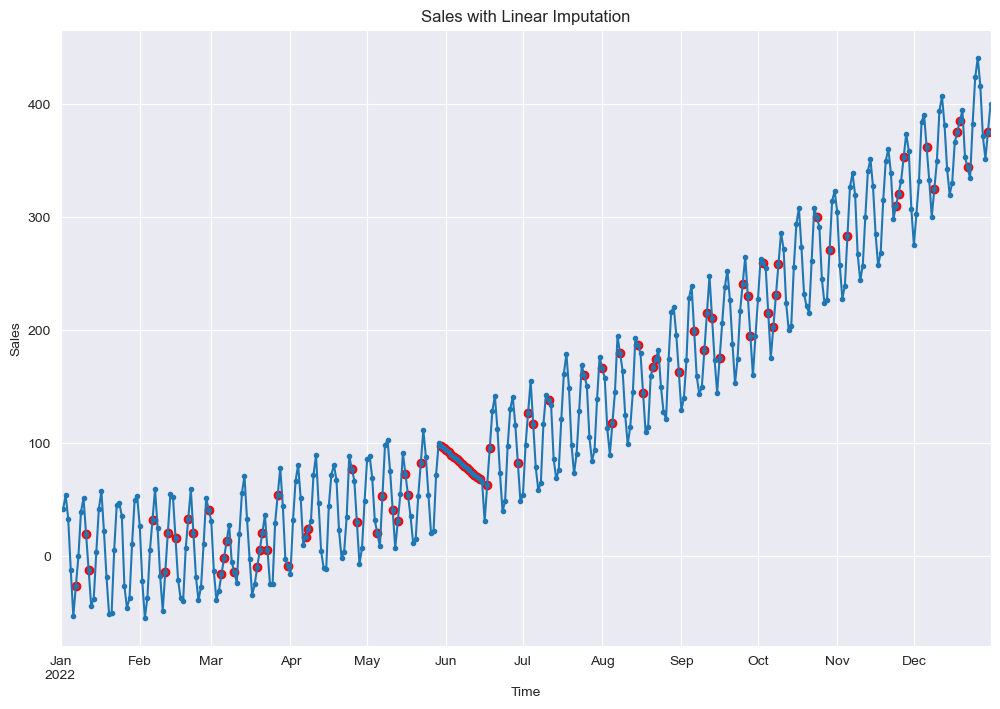

In [28]:


imputed_df = df.interpolate(method='linear', limit_direction='forward')



imputed_df['sales'].plot(style='.-', figsize=(12,8), title='Sales with Linear Imputation')

# Mark the missing values 
imputed_indices = df[df['sales'].isnull()].index


# Add points where data was imputed with red color
plt.scatter(imputed_indices, imputed_df.loc[imputed_indices, 'sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

# Spline imputation

Text(0, 0.5, 'Sales')

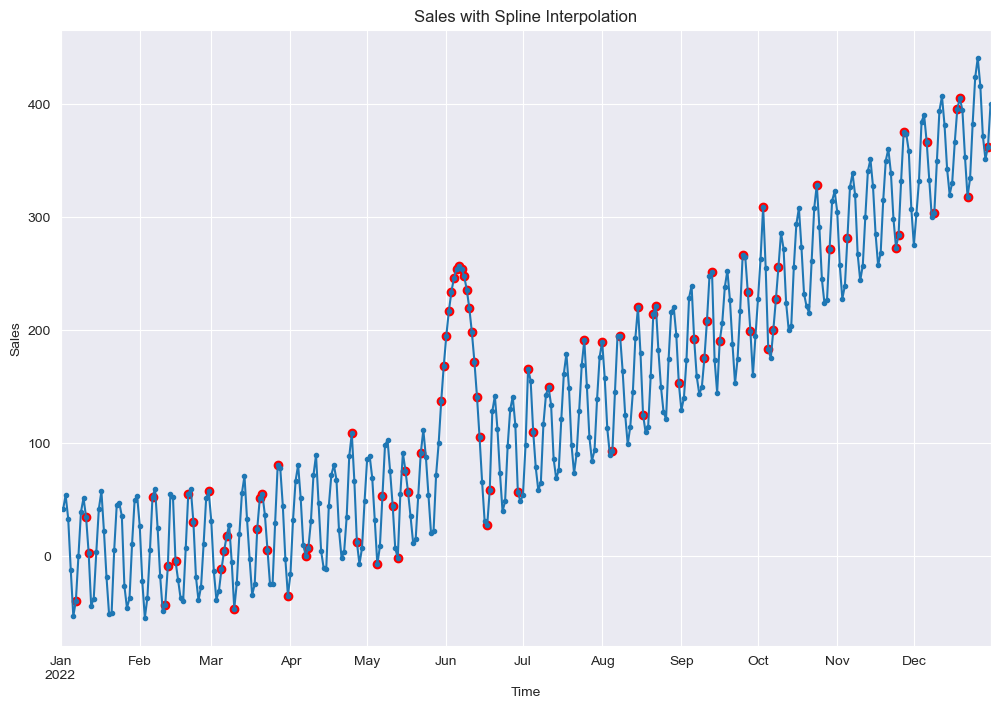

In [33]:
# Apply the spline interpolation method
df_imputed = df.interpolate(method='spline', limit_direction='forward', order=2)

# Plot the main line with markers
df_imputed['sales'].plot(style='.-', figsize=(12,8), title='Sales with Spline Interpolation')

# Add points where data was imputed with red color
imputed_indices = df[df['sales'].isnull()].index
plt.scatter(imputed_indices, df_imputed.loc[imputed_indices, 'sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')


## Regression Imputation

Text(0, 0.5, 'Sales')

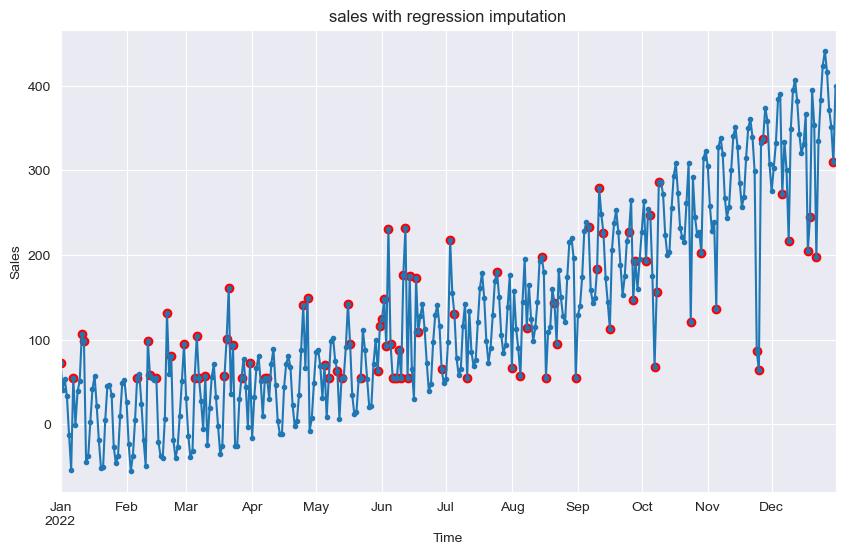

In [36]:
df_imputed = df.copy()
df_non_missing = df.dropna()


# initiate the model
model = LinearRegression()

# Reshape data for model fitting (sklearn requires 2D array for predictors)
X = df_non_missing['ad_spent'].values.reshape(-1,1)
y = df_non_missing['sales'].values

model.fit(X, y)

missing_sales_indices = df_imputed[df_imputed['sales'].isnull()].index

predicted_sales = model.predict(df_imputed.loc[missing_sales_indices, 'ad_spent'].values.reshape(-1, 1))

# filling the missing sales with the predict value
df_imputed.loc[missing_sales_indices, 'sales'] = predicted_sales

df_imputed['sales'].plot(style='.-', figsize=(10, 6), title='sales with regression imputation')

plt.scatter(missing_sales_indices, predicted_sales, color='red', label='Regression Imputation')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')


## K Nearest Neibors(KNN) Imputation

Text(0, 0.5, 'Sales')

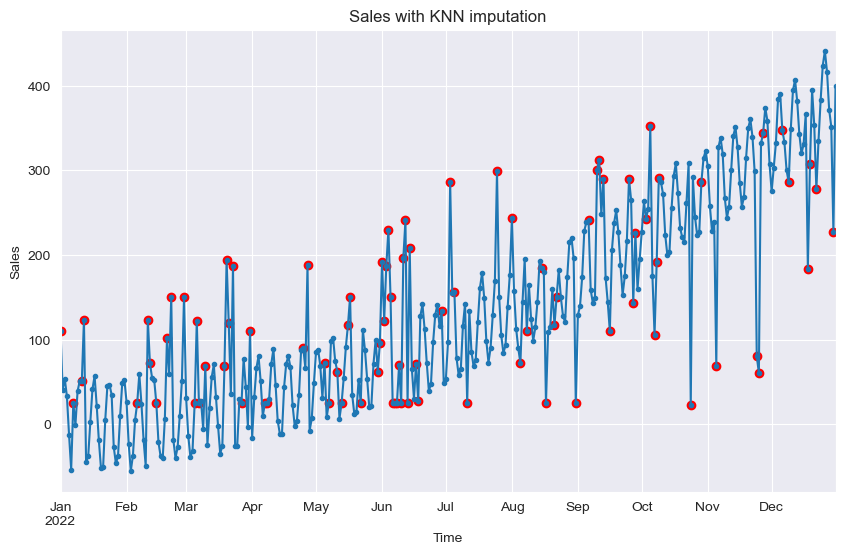

In [39]:
imputer = KNNImputer(n_neighbors=3)

df_imputed = df.copy()
df_imputed[['sales','ad_spent']] = imputer.fit_transform(df_imputed[['sales','ad_spent']])

plt.figure(figsize=(10,6))
df_imputed['sales'].plot(style='.-', label='sales')

missing_indices = df[df['sales'].isnull()].index

plt.scatter(missing_indices, df_imputed.loc[missing_indices, 'sales'], color='red', label='KNN imputation')

plt.title('Sales with KNN imputation')
plt.xlabel('Time')
plt.ylabel('Sales')

## Seasonal Trend decomposition using Loess(STL) Imputation

Text(0.5, 1.0, 'Sales with STL imputation')

c:\Users\yacht\anaconda3\Lib\site-packages\numpy\ma\extras.py:289: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
c:\Users\yacht\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:2024: UserWarning: Warning: converting a masked element to nan.
  result = asarray(a).shape
c:\Users\yacht\anaconda3\Lib\site-packages\numpy\ma\extras.py:289: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
c:\Users\yacht\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:2024: UserWarning: Warning: converting a masked element to nan.
  result = asarray(a).shape
c:\Users\yacht\anaconda3\Lib\site-packages\numpy\ma\extras.py:289: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
c:\Users\yacht\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:2024: UserWarning: Warning: converting a m

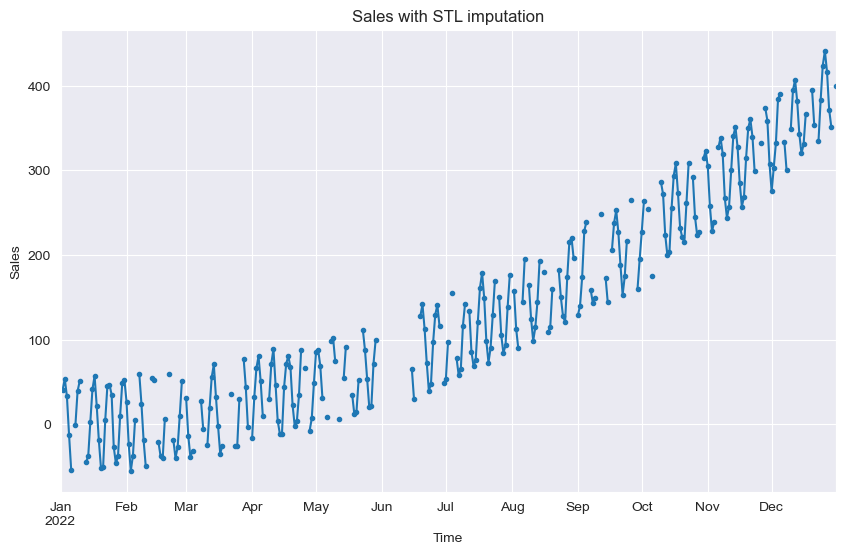

In [41]:
df_copy = df.copy()

imputed_indices = df[df['sales'].isnull()].index

# apply the STL decomposition

stl = STL(df_copy['sales'].interpolate(), seasonal=31)
result = stl.fit()

# extract the trend and seasonal component
seasonal_component = result.seasonal
trend = result.trend
resid = result.resid


# Interpolate missing value in the deseasonalized series
seasonlized_imputed = seasonal_component.interpolate(method='linear')
trend_filled = trend.interpolate(method='linear')
resid_filled = resid.interpolate(method='linear')

# add the seasonal component to create the final imputed series
df_imputed = seasonal_component + trend_filled + resid_filled

# update the original dateframe with the imputed values
df_copy.loc[imputed_indices, 'sales'] = df_imputed[imputed_indices]


plt.figure(figsize=(10, 6))
df_copy['sales'].plot(style='.-', label='STL imputation')
plt.scatter(imputed_indices, df_copy.loc[imputed_indices,'sales'], color='red')

plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales with STL imputation')





# Time Series outliers detection and Imputation


## Generate Data

,sales
date,
2022-01-01,8.830262
2022-01-02,41.116283
2022-01-03,53.683909
2022-01-04,32.968355
2022-01-05,-12.254839


% missing data in sales:  0.0


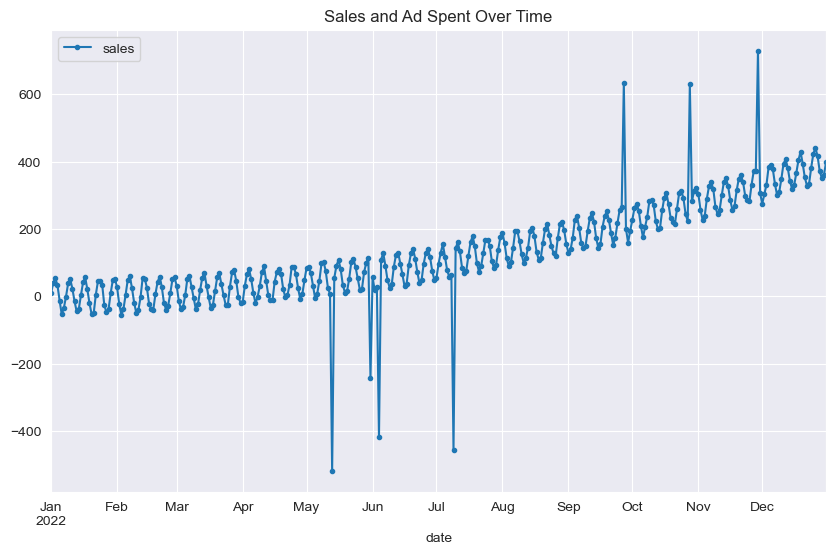

In [49]:
sns.set_style("darkgrid")
# Set the random seed for reproducibility
np.random.seed(0)

# Define the start date
start_date = datetime(2022, 1, 1)

# Generate dates for 365 days
dates = [start_date + timedelta(days=i) for i in range(365)]

# Generate more pronounced trend component (increasing linearly)
trend = np.power(np.linspace(0.1, 20, 365), 2)

# Generate more pronounced seasonal component (sinusoidal pattern) with weekly period
seasonal = 50 * np.sin(np.linspace(0, 2 * np.pi * 52, 365)) # 52 weeks in a year

# Generate random noise
noise = np.random.normal(0, 5, 365)

# Combine components to generate sales data
sales = trend + seasonal + noise

# Create a dataframe
df = pd.DataFrame(
    {
        'date': dates,
        'sales': sales,
        # 'ad_spent': ad_spent
    }
)

# Set the date as the index
df.set_index('date', inplace=True)

# Randomly choose indices for outliers
random_indices = random.sample(list(set(range(365))), int(0.02 * 365))

# Add random outliers
offset = np.max(df['sales'])-np.mean(df['sales'])
mean_value = np.mean(df['sales'])
for i in random_indices:
    if df.iloc[i, df.columns.get_loc('sales')] <= mean_value:
        df.iloc[i, df.columns.get_loc('sales')] = df.iloc[i, df.columns.get_loc('sales')] - (1+random.random())*offset
    else:
        df.iloc[i, df.columns.get_loc('sales')] = df.iloc[i, df.columns.get_loc('sales')] + (1+random.random())*offset

# Display the dataframe
display(df.head())

# Print the percentage of missing values 
print('% missing data in sales: ', 100*df['sales'].isnull().sum()/len(df))

# Plot the data
df[['sales']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')
plt.show()


## box plot

<Axes: ylabel='sales'>

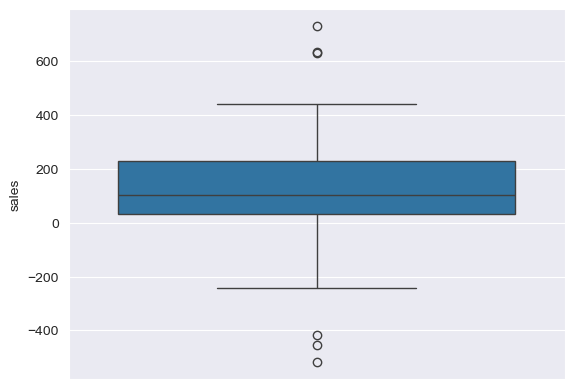

In [51]:
sns.boxplot(df['sales'])

## Inter_quartile Range


,sales,original_sales
date,,
2022-01-01,8.830262,8.830262
2022-01-02,41.116283,41.116283
2022-01-03,53.683909,53.683909
2022-01-04,32.968355,32.968355
2022-01-05,-12.254839,-12.254839


<Axes: title={'center': 'Sales and Ad Spent Over Time'}, xlabel='date'>

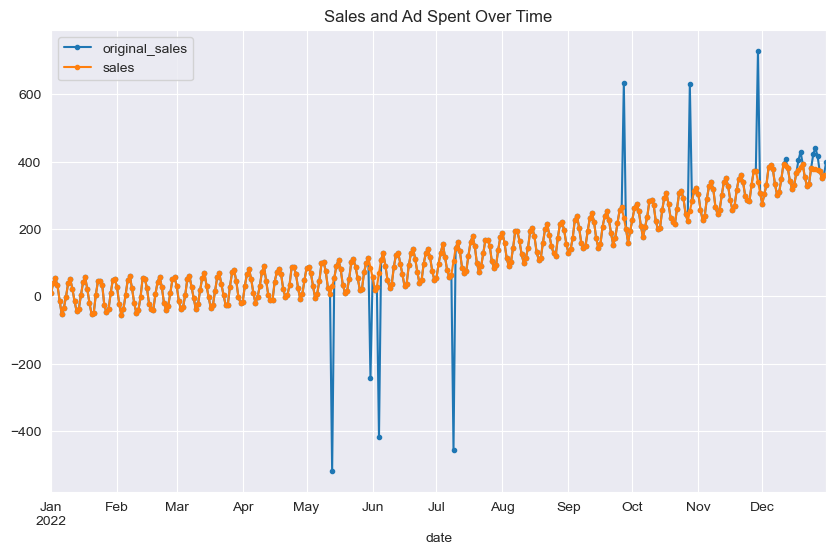

In [56]:
from numpy import NaN

IQR = np.quantile(df['sales'], 0.75) - np.quantile(df['sales'], 0.25) 
outliers = df[(df.values > np.median(df['sales']) + 1.5*IQR) | (df.values < np.median(df['sales']) - 1.5*IQR)].values
df_with_NaN = df.replace(outliers, NaN)
df_new = df_with_NaN.interpolate(method='linear', axis=0).ffill().bfill()
df_new['original_sales'] = df['sales']

display(df_new.head())

df_new[['original_sales','sales']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')

## Z score

,sales,original_sales
date,,
2022-01-01,8.830262,8.830262
2022-01-02,41.116283,41.116283
2022-01-03,53.683909,53.683909
2022-01-04,32.968355,32.968355
2022-01-05,-12.254839,-12.254839


<Axes: xlabel='date'>

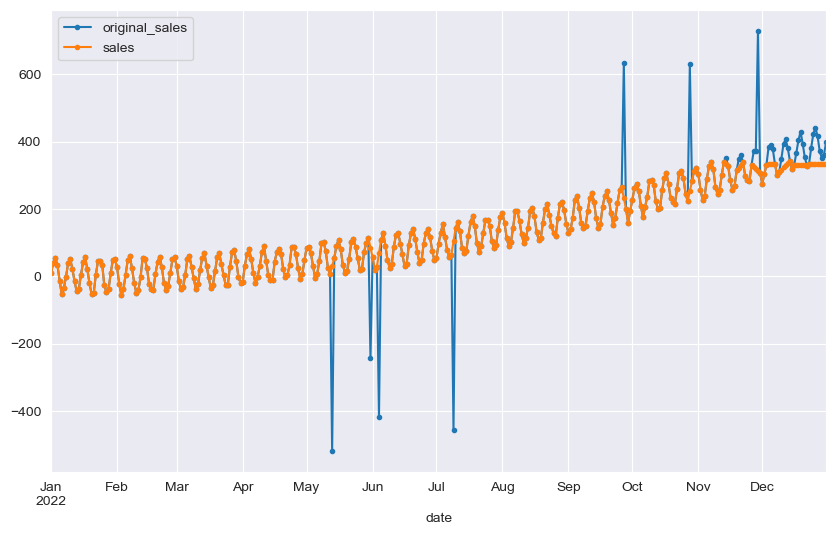

In [61]:
from scipy import stats

threhold = 1.5
z_score = stats.zscore(df['sales'])
outliers = df[abs(z_score.values)>threhold].values

df_with_NaN = df.replace(outliers, NaN)
df_new = df_with_NaN.interpolate(method='linear', axis=0).ffill().bfill()
df_new['original_sales'] = df['sales']

display(df_new.head())

df_new[['original_sales','sales']].plot(style='.-', figsize=(10, 6))


## decomposition

,sales
date,
2022-01-01,8.830262
2022-01-02,41.116283
2022-01-03,53.683909
2022-01-04,32.968355
2022-01-05,-12.254839


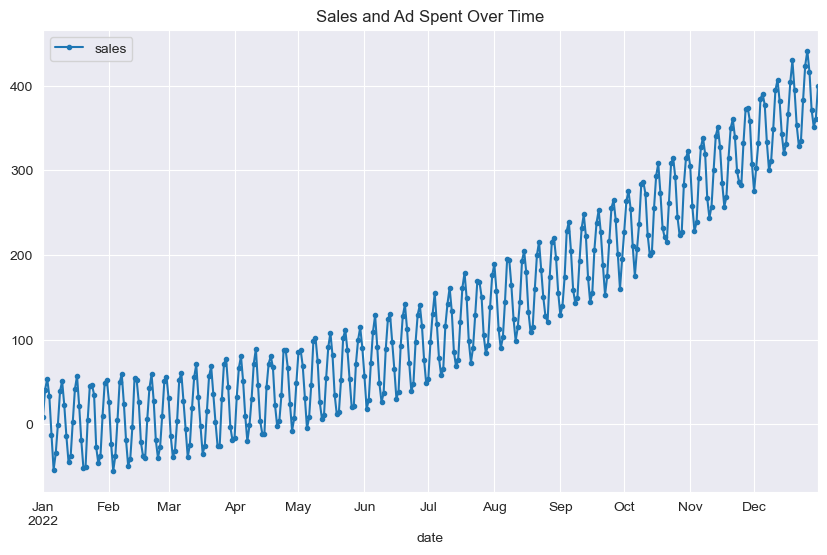

In [65]:
sns.set_style("darkgrid")
# Set the random seed for reproducibility
np.random.seed(0)

# Define the start date
start_date = datetime(2022, 1, 1)

# Generate dates for 365 days
dates = [start_date + timedelta(days=i) for i in range(365)]

# Generate more pronounced trend component (increasing linearly)
trend = np.power(np.linspace(0.1, 20, 365), 2)

# Generate more pronounced seasonal component (sinusoidal pattern) with weekly period
seasonal = 50 * np.sin(np.linspace(0, 2 * np.pi * 52, 365)) # 52 weeks in a year

# Generate random noise
noise = np.random.normal(0, 5, 365)

# Combine components to generate sales data
sales = trend + seasonal + noise

# Create a dataframe
df = pd.DataFrame(
    {
        'date': dates,
        'sales': sales,
        # 'ad_spent': ad_spent
    }
)

# Set the date as the index
df.set_index('date', inplace=True)



# Display the dataframe
display(df.head())


# Plot the data
df[['sales']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')
plt.show()

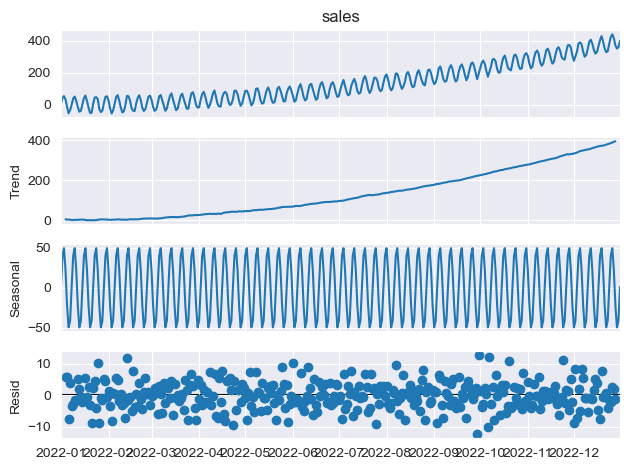

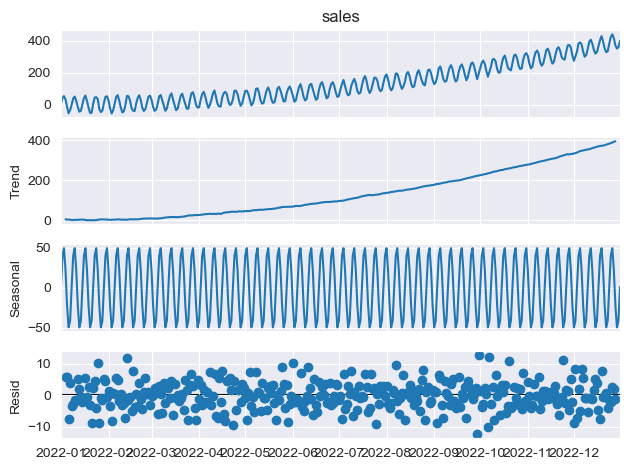

In [72]:
result = seasonal_decompose(df['sales'], model='additive', period=7)
result.plot()